In [3]:
import json
import numpy as np
import pandas as pd

In [2]:
cards = pd.read_json('cards.json')
cards.drop(columns=['description', 'arena'], inplace=True)
cards = cards.set_index('key')

In [3]:
cards

,name,sc_key,elixir,type,rarity,id
key,,,,,,
knight,Knight,Knight,3,Troop,Common,26000000
archers,Archers,Archer,3,Troop,Common,26000001
goblins,Goblins,Goblins,2,Troop,Common,26000002
giant,Giant,Giant,5,Troop,Rare,26000003
pekka,P.E.K.K.A,Pekka,7,Troop,Epic,26000004
...,...,...,...,...,...,...
earthquake,Earthquake,Earthquake,3,Spell,Rare,28000014
barbarian-barrel,Barbarian Barrel,BarbLog,2,Spell,Epic,28000015
heal-spirit,Heal Spirit,Heal,1,Troop,Rare,28000016


In [4]:
cards.to_csv('data/cards.csv')

In [5]:
with open('cards_stats.json') as file:
    cards_stats_full = json.load(file)
# print(cards_stats_full['characters'][0])

In [6]:
name_to_key = {}
for i in cards_stats_full:
    for j in cards_stats_full[i]:
        if 'key' in j:
            name_to_key[j['name']] = {j['key']}
            if 'summon_character' in j:
                if j['summon_character'] not in name_to_key:
                    name_to_key[j['summon_character']] = {j['key']}
                else:
                    name_to_key[j['summon_character']].add(j['key'])

In [7]:
cards_by_key = {i: {} for i in cards.index.values}
cards_by_name = {}
for i in cards_stats_full:
#     print('---------------------------')
#     print(i)
#     print('------')
#     print(cards_stats_full[i][0].keys())
#     print('---------------------------')
    for j in cards_stats_full[i]:
        name = j['name']
        cards_by_name[name] = j
        
        if name in name_to_key:
            for k in name_to_key[name]:
                if k is not None:
                    cards_by_key[k] = {**j, **cards_by_key[k]}

            
        if 'key' in j:
            if j['key'] in cards_by_key:
                cards_by_key[j['key']] = {**cards_by_key[j['key']] , **j}
            else:
                cards_by_key[j['key']] = j

In [8]:
detail = {}
missing = {}
for i in cards.index.values:
    if len(cards_by_key[i]) != 0:
        detail[i] = cards_by_key[i]
    else:
        detail[i] = None
        missing[i] = None
missing

{'elixir-collector': None,
 'fireball': None,
 'arrows': None,
 'rocket': None,
 'goblin-barrel': None,
 'mirror': None,
 'the-log': None,
 'barbarian-barrel': None,
 'giant-snowball': None}

In [9]:
missing['elixir-collector'] = 'ElixirCollector'
missing['fireball'] = 'FireballSpell'
missing['arrows'] = 'ArrowsSpell'
missing['rocket'] = 'RocketSpell'
missing['goblin-barrel'] = 'GoblinBarrelSpell'
missing['the-log'] = 'LogProjectile'
missing['giant-snowball'] = 'SnowballSpell'
missing['barbarian-barrel'] = 'BarbLogProjectile'

for i in missing:
    if missing[i] is not None:
        detail[i] = cards_by_name[missing[i]]

In [10]:
detail['knight']['attacks_ground']

True

In [11]:
def add_attribute(att):
    cards[att] = np.nan
    for i in cards.index.values:
        if detail[i] is not None and att in detail[i]:
            cards.loc[i, att] = detail[i][att]
    return cards

In [12]:
attributes = {'range', 'attacks_ground', 'attacks_air', 'flying_height', 'hits_ground', 'hits_air', 'aoe_to_ground', 'aoe_to_air'}
for i in attributes:
    add_attribute(i)

In [13]:
cards.fillna(False, inplace=True)
cards['range'] = cards['range'].astype(int)
cards['flying_height'] = cards['flying_height'].astype(int)
cards['damage_air'] = cards['hits_air'] | cards['attacks_air'] | cards['aoe_to_air']
cards['damage_ground'] = cards['hits_ground'] | cards['attacks_ground'] | cards['aoe_to_ground']
cards.drop(columns=['hits_air', 'attacks_air', 'aoe_to_air', 'hits_ground', 'attacks_ground', 'aoe_to_ground'], inplace=True)

In [14]:
cards

,name,sc_key,elixir,type,rarity,id,flying_height,range,damage_air,damage_ground
key,,,,,,,,,,
knight,Knight,Knight,3,Troop,Common,26000000,0,1200,False,True
archers,Archers,Archer,3,Troop,Common,26000001,0,5000,True,True
goblins,Goblins,Goblins,2,Troop,Common,26000002,0,500,False,True
giant,Giant,Giant,5,Troop,Rare,26000003,0,1200,False,True
pekka,P.E.K.K.A,Pekka,7,Troop,Epic,26000004,0,1200,False,True
...,...,...,...,...,...,...,...,...,...,...
earthquake,Earthquake,Earthquake,3,Spell,Rare,28000014,0,0,False,True
barbarian-barrel,Barbarian Barrel,BarbLog,2,Spell,Epic,28000015,0,0,False,True
heal-spirit,Heal Spirit,Heal,1,Troop,Rare,28000016,0,0,True,True


In [15]:
cards.to_csv('data/cards.csv')

In [16]:
import os
for i in os.walk('battles'):
    _, _, files = i

In [17]:
players = []
for filename in files:
    with open(f'battles/{filename}') as file:
        try:
            t = json.load(file)
            players.append(t)
        except:
            print("Error at " + filename)
print(len(players))

3420


In [18]:
# print(players[0][10].keys())

In [19]:
# print(players[0][10]['team'][0]['cards'][0].keys())

In [20]:
# files[0]

In [21]:
def add_battle(battles, b):
    if len(b['team']) != 1 or len(b['opponent']) != 1: 
        return
    team = b['team'][0]
    op = b['opponent'][0]
    tmp = {}
    
    for p, info in enumerate([team, op]):
        player = p + 1
        if 'startingTrophies' not in info:
            return
        tmp[f'p{player}_tag'] = info['tag']
        tmp[f'p{player}_trophy'] = info['startingTrophies']
        for i, c in enumerate(info['cards']):
            tmp[f'p{player}_card_{i}_id'] = c['id']
            tmp[f'p{player}_card_{i}_lv'] = c['level']
        tmp[f'p{player}_crowns'] = info['crowns']
    tmp['winner'] =  1 if team['crowns'] > op['crowns'] else (2 if team['crowns'] < op['crowns'] else 0)
    battles.append(tmp)
    

In [23]:
battles = []
types_filter = {'PvP'}
card_info_filter = {'id', 'name', 'level'}
for player in players:
    for battle in player:
        # print(battle)
        if battle['type'] in types_filter:
            add_battle(battles, battle)
print(len(battles))
            

reason


TypeError: string indices must be integers

In [23]:
battle_df = {i: [] for i in battles[0].keys()}
for i in battles:
    for k in battle_df:
        battle_df[k].append(i[k])
    

In [24]:
battle_df = pd.DataFrame.from_dict(battle_df)

In [25]:
battle_df

,p1_tag,p1_trophy,p1_card_0_id,p1_card_0_lv,p1_card_1_id,p1_card_1_lv,p1_card_2_id,p1_card_2_lv,p1_card_3_id,p1_card_3_lv,...,p2_card_4_id,p2_card_4_lv,p2_card_5_id,p2_card_5_lv,p2_card_6_id,p2_card_6_lv,p2_card_7_id,p2_card_7_lv,p2_crowns,winner
0,#LYCGVUPY,7273,26000036,12,26000042,6,28000000,12,28000008,14,...,26000032,6,26000037,6,28000001,14,26000008,14,0,1
1,#LYCGVUPY,7242,26000036,12,26000042,6,28000000,12,28000008,14,...,26000042,6,26000062,6,28000000,12,28000008,14,0,1
2,#LYCGVUPY,7269,26000036,12,26000042,6,28000000,12,28000008,14,...,28000015,9,27000009,12,28000012,9,28000007,9,1,2
3,#LYCGVUPY,7236,26000036,12,26000042,6,28000000,12,28000008,14,...,26000007,9,28000000,12,26000006,9,28000005,9,1,1
4,#LYCGVUPY,7208,26000036,12,26000042,6,28000000,12,28000008,14,...,26000033,6,26000012,9,28000001,14,26000018,12,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1421,#88828JC9,6251,26000069,4,26000007,9,27000001,12,28000010,6,...,26000042,6,26000083,6,28000002,8,28000008,14,1,1
1422,#88828JC9,6225,26000069,4,26000007,9,27000001,12,28000010,6,...,28000011,6,26000014,12,26000000,14,28000000,12,0,1
1423,#88828JC9,6253,26000069,4,26000007,9,27000001,12,28000010,6,...,26000055,6,26000041,14,28000001,14,26000046,6,3,2
1424,#88828JC9,6224,26000069,4,26000007,9,27000001,12,28000010,6,...,27000003,12,26000084,14,28000011,6,26000025,9,0,1


In [26]:
battle_df.to_csv('data/battles.csv')

In [2]:
raise NotImplementedError

NotImplementedError: 

In [30]:
df3 = pd.read_csv('data/battles.csv')

In [31]:
df1 = pd.read_csv('data-cp/battles.csv')

In [32]:
df2 = pd.read_csv('data-cp/battles.csv')

In [33]:
df1.describe()

,Unnamed: 0,p1_trophy,p1_card_0_id,p1_card_0_lv,p1_card_1_id,p1_card_1_lv,p1_card_2_id,p1_card_2_lv,p1_card_3_id,p1_card_3_lv,...,p2_card_4_id,p2_card_4_lv,p2_card_5_id,p2_card_5_lv,p2_card_6_id,p2_card_6_lv,p2_card_7_id,p2_card_7_lv,p2_crowns,winner
count,39348.000000,39348.000000,3.934800e+04,39348.000000,3.934800e+04,39348.000000,3.934800e+04,39348.000000,3.934800e+04,39348.000000,...,3.934800e+04,39348.000000,3.934800e+04,39348.000000,3.934800e+04,39348.000000,3.934800e+04,39348.000000,39348.000000,39348.000000
mean,19673.500000,3265.247865,2.637071e+07,5.205347,2.643079e+07,5.352318,2.647209e+07,5.426629,2.664460e+07,5.640515,...,2.665710e+07,5.548999,2.645663e+07,5.547093,2.646050e+07,5.609332,2.651788e+07,5.501372,1.123361,1.485895
std,11358.933533,1341.853424,7.525037e+05,2.897258,7.924342e+05,2.872361,8.226453e+05,2.911471,9.083877e+05,2.951192,...,9.104772e+05,2.814955,8.020064e+05,2.836618,8.061877e+05,2.872803,8.468811e+05,2.851956,1.092620,0.500062
min,0.000000,23.000000,2.600000e+07,1.000000,2.600000e+07,1.000000,2.600000e+07,1.000000,2.600000e+07,1.000000,...,2.600000e+07,1.000000,2.600000e+07,1.000000,2.600000e+07,1.000000,2.600000e+07,1.000000,0.000000,0.000000
25%,9836.750000,2600.000000,2.600001e+07,3.000000,2.600001e+07,3.000000,2.600001e+07,3.000000,2.600001e+07,3.000000,...,2.600001e+07,3.000000,2.600001e+07,3.000000,2.600001e+07,3.000000,2.600001e+07,3.000000,0.000000,1.000000
50%,19673.500000,3561.000000,2.600002e+07,5.000000,2.600002e+07,5.000000,2.600002e+07,5.000000,2.600003e+07,5.000000,...,2.600004e+07,5.000000,2.600002e+07,5.000000,2.600002e+07,5.000000,2.600003e+07,5.000000,1.000000,1.000000
75%,29510.250000,3985.000000,2.600006e+07,7.000000,2.600006e+07,7.000000,2.700000e+07,7.000000,2.800000e+07,8.000000,...,2.800000e+07,7.000000,2.700000e+07,7.000000,2.700000e+07,8.000000,2.700001e+07,7.000000,2.000000,2.000000
max,39347.000000,6470.000000,2.800002e+07,14.000000,2.800002e+07,14.000000,2.800002e+07,14.000000,2.800002e+07,14.000000,...,2.800002e+07,14.000000,2.800002e+07,14.000000,2.800002e+07,14.000000,2.800002e+07,14.000000,3.000000,2.000000


In [34]:
df = pd.concat([df3, df1])

In [35]:
df.reset_index(inplace=True)
df.drop(columns=['index', 'Unnamed: 0'], inplace=True)

In [36]:
df.describe()

,p1_trophy,p1_card_0_id,p1_card_0_lv,p1_card_1_id,p1_card_1_lv,p1_card_2_id,p1_card_2_lv,p1_card_3_id,p1_card_3_lv,p1_card_4_id,...,p2_card_4_id,p2_card_4_lv,p2_card_5_id,p2_card_5_lv,p2_card_6_id,p2_card_6_lv,p2_card_7_id,p2_card_7_lv,p2_crowns,winner
count,54558.000000,5.455800e+04,54558.000000,5.455800e+04,54558.000000,5.455800e+04,54558.000000,5.455800e+04,54558.000000,5.455800e+04,...,5.455800e+04,54558.000000,5.455800e+04,54558.000000,5.455800e+04,54558.000000,5.455800e+04,54558.000000,54558.000000,54558.000000
mean,4005.229536,2.640762e+07,6.592415,2.646853e+07,6.686407,2.650099e+07,6.805015,2.666058e+07,6.954617,2.664013e+07,...,2.664225e+07,6.875362,2.651305e+07,6.879156,2.654514e+07,6.929616,2.661142e+07,6.828146,1.028538,1.469904
std,1651.431390,7.764509e+05,3.670801,8.155463e+05,3.612161,8.353977e+05,3.690447,9.089260e+05,3.635645,8.966986e+05,...,9.000983e+05,3.595898,8.334734e+05,3.609807,8.531666e+05,3.619228,8.913273e+05,3.621584,1.049768,0.499318
min,23.000000,2.600000e+07,1.000000,2.600000e+07,1.000000,2.600000e+07,1.000000,2.600000e+07,1.000000,2.600000e+07,...,2.600000e+07,1.000000,2.600000e+07,1.000000,2.600000e+07,1.000000,2.600000e+07,1.000000,0.000000,0.000000
25%,3000.000000,2.600001e+07,4.000000,2.600001e+07,4.000000,2.600001e+07,4.000000,2.600002e+07,4.000000,2.600002e+07,...,2.600002e+07,4.000000,2.600001e+07,4.000000,2.600001e+07,4.000000,2.600002e+07,4.000000,0.000000,1.000000
50%,3914.000000,2.600003e+07,6.000000,2.600003e+07,6.000000,2.600003e+07,6.000000,2.600004e+07,7.000000,2.600004e+07,...,2.600004e+07,6.000000,2.600003e+07,6.000000,2.600003e+07,7.000000,2.600004e+07,6.000000,1.000000,1.000000
75%,5734.000000,2.600006e+07,9.000000,2.700000e+07,9.000000,2.700001e+07,9.000000,2.800000e+07,9.000000,2.800000e+07,...,2.800000e+07,9.000000,2.700001e+07,9.000000,2.700001e+07,9.000000,2.800000e+07,9.000000,2.000000,2.000000
max,7268.000000,2.800002e+07,14.000000,2.800002e+07,14.000000,2.800002e+07,14.000000,2.800002e+07,14.000000,2.800002e+07,...,2.800002e+07,14.000000,2.800002e+07,14.000000,2.800002e+07,14.000000,2.800002e+07,14.000000,3.000000,2.000000


In [37]:
df.to_csv('data/battles.csv')

<AxesSubplot:>

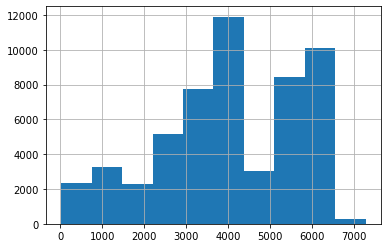

In [42]:
df['p1_trophy'].hist()

In [41]:
df3.to_csv('data-cp2/battles2.csv')